In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cProfile
import pandas as pd
import geopandas as geopd
import json
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import src.utils.geometry as geo
import src.utils.make_config as make_config
import src.utils.scales as scales
import src.utils.places_to_cells as places_to_cells
import src.data.shp_extract as shp_extract
import src.data.metrics as metrics
import src.utils.places_to_cells as places_to_cells
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
import src.models.mobility as mobility
from dotenv import load_dotenv
load_dotenv()
pd.reset_option("display.max_rows")

# Config

In [537]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
mapbox_token = os.environ['MAPBOX_TOKEN']
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
latlon_proj = 'epsg:4326'
user_level_label = '{}-speakers'

country_codes = ('BE', 'BO', 'CA', 'CH', 'EE', 'ES', 'FR', 'HK', 'ID', 'LT', 
                 'LV', 'MY', 'PE', 'RO', 'SG', 'TN', 'UA')
with open(os.path.join(external_data_dir, 'countries.json'), encoding='utf-8') as f:
    countries_study_data = json.load(f)
with open(os.path.join(external_data_dir, 'langs_agg.json')) as f:
    langs_agg_dict = json.load(f)
fig_dir = os.path.join('..', 'reports', 'figures')
save_path_format = os.path.join(
    fig_dir, '{cc}', '{metric}', 
    '{metric}_{region}_{grp}cell_size={cell_size}m.pdf')

In [243]:
publication_plot = True
plt.rc('text', usetex=publication_plot)
if publication_plot:
    small_size = 7
    plt.rc('font', size=small_size)
    plt.rc('axes', labelsize=small_size+3)
    plt.rc('xtick', labelsize=small_size)
    plt.rc('ytick', labelsize=small_size)
    plt.rc('legend', fontsize=small_size, title_fontsize=small_size)
    plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern} \renewcommand{\familydefault}{\sfdefault}'
    # Set to a column width, then to be adjusted by a factor.
    column_width_in = 8.7 / 2.54
    intercol_width_in = (17.8-8.7*2) / 2.54
    plt.rcParams["figure.figsize"] = (column_width_in, column_width_in*3/4)
    plt.rcParams["xtick.major.size"] = 2
    plt.rcParams["ytick.major.size"] = plt.rcParams["xtick.major.size"]
else:
    plt.rc('font', size=11)
    plt.rcParams["figure.figsize"] = (10, 6)
    
annotate_kwargs = {'fontfamily': 'Helvetica', 'fontsize': 14,
                   'usetex': False}
annotations = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]

In [455]:
count_dict = {'name': 'count', 'readable': 'Number', 'log_scale': True,
              'total_count_col': 'total_count', 'vmin': 1, 'cmap': 'Purples'}
repr_dict = {'name': 'repr', 'readable': 'Representation', 'log_scale': True,
             'total_count_col': 'total_count', 'sym_about': 1}
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
conc_dict = {'name': 'conc', 'readable': 'Concentration', 'log_scale': False, 
             'total_count_col': 'total_count'}
KL_dict = {'name': 'KL', 'readable': 'KL divergence', 'global_norm': True,
           'scale_fun': metrics.max_kl, 'log_scale': False,
           'total_count_col': 'total_count', 'sym_about': 0}
KL_props_dict = {'name': 'KL_props', 'readable': 'KL divergence', 'log_scale': False,
                 'total_count_col': 'local_count', 'cmap': 'Reds'}
Hc_dict = {'name': 'Hc', 'readable': 'Concentration entropy', 
           'scale_fun': metrics.null_Hc, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1, 
           'global_norm': False}
Hp_dict = {'name': 'Hp', 'readable': 'Relative proportion entropy', 
           'scale_fun': metrics.null_Hp, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1,
           'cbar_label': r'$H_i^p / H_{\mathrm{null}}^p$'}
EMD_dict = {'name': 'EMD', 'readable': "Earth mover's distance", 
            'log_scale': False, 'total_count_col': 'total_count'}
EMR_dict = {'name': 'EMR', 'readable': "Earth Mover's Ratio",
            'pattern': 'EMR_{grp}_vs_tot',
            'log_scale': False, 'total_count_col': 'total_count'}
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}

# Stat significance tests

In [5]:
cc = 'BE'
region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, 'Apn_AdRe.shp', 'Apn_AdRe.shp')
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=10**4, simplify_tol=50)

cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [131]:
d_matrix = None
norm = None
nr_iter = 100
N_samples_arr = [100,200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000,
                 3000, 4000, 5000, 7000, 10000, 50000, 100000]
res_dict = {N_samples: np.zeros(nr_iter) for N_samples in N_samples_arr}
for N_samples in N_samples_arr:
    # draws could be made here, in nr_iter x N_samples matrix
    res_dict[N_samples] = np.zeros(nr_iter)
    for k in range(nr_iter):
        draw = np.random.random(N_samples)
        cum_distrib = cell_plot_df['total_conc'].cumsum().values
        assignment = np.searchsorted(cum_distrib, draw)
        i_cells, counts = np.unique(assignment, return_counts=True)
        cell_plot_df['sample_conc'] = 0
        cell_plot_df['sample_conc'].iloc[i_cells] = counts / N_samples
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            cell_plot_df, 'sample_conc', 'total_conc', d_matrix=d_matrix, norm=norm)
        res_dict[N_samples][k] = emd_value / norm
    print(f'{nr_iter} iterations done for N_samples={N_samples}')

/home/thomaslouf/Documents/code/multiling-twitter/.cenv/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100 iterations done for N_samples=1500
100 iterations done for N_samples=7000
100 iterations done for N_samples=50000


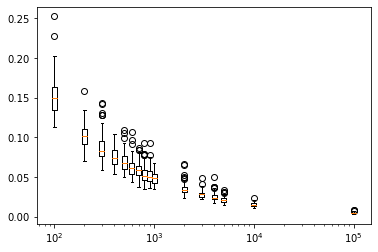

In [129]:
fig, ax = plt.subplots()
xticks = list(res_dict.keys())
emr_samples = [emr for emr in res_dict.values()]
w = 0.05
width_fun = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
_ = ax.boxplot(emr_samples, widths=width_fun(xticks, w), positions=xticks)
ax.set_xscale('log')
fig.show()

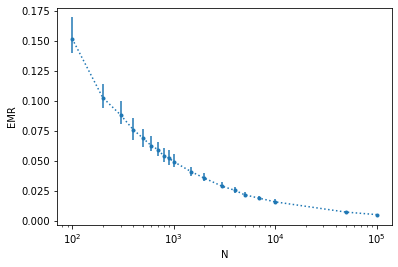

In [155]:
fig, ax = plt.subplots()
xticks = list(res_dict.keys())
emr_samples = np.asarray([emr for emr in res_dict.values()])
emr_means = np.mean(emr_samples, axis=1)
yerr = [np.percentile(emr_samples, 75, axis=1) - emr_means,
        emr_means - np.percentile(emr_samples, 25, axis=1)]
ax.errorbar(xticks, emr_means, yerr=yerr, marker='.', linestyle='dotted')
ax.set_xscale('log')
ax.set_xlabel('N')
ax.set_ylabel('EMR')
fig.savefig('EMR_stats.pdf')
fig.show()

# Countries "phase space"

In [952]:
metrics_save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
countries_dict = {
    'Uruguay': {'cc': 'UY', 'region': None, 'cell_sizes': [20000]},
    'Paraguay': {'cc': 'PY', 'region': None, 'cell_sizes': [30000, 40000]},
    'Cyprus': {'cc': 'CY', 'region': None, 'cell_sizes': [5000, 10000]},
    'Luxembourg': {'cc': 'LU', 'region': None, 'cell_sizes': [2000, 5000]},
    'Algeria': {'cc': 'DZ', 'region': None, 'cell_sizes': [40000, 60000]},
    'Morocco': {'cc': 'MA', 'region': None, 'cell_sizes': [20000, 40000]},
    'Finland': {'cc': 'FI', 'region': None, 'cell_sizes': [40000]},
    'SG': {'region': None, 'cell_sizes': [1000, 2000]},
    'Switzerland': {'cc': 'CH', 'region': None, 'cell_sizes': [10000, 15000]},
    'Belgium': {'cc': 'BE', 'region': None, 'cell_sizes': [5000, 10000, 15000]},
    'Catalonia': {'cc': 'ES', 'region': 'Catalonia', 'cell_sizes': [5000, 10000, 15000]},
    'Balearic islands': {'cc': 'ES', 'region': 'Balearic islands', 'cell_sizes': [5000, 10000]},
    'Galicia': {'cc': 'ES', 'region': 'Galicia', 'cell_sizes': [10000]},
    'Valencian Community': {'cc': 'ES', 'region': 'Valencian Community', 'cell_sizes': [5000, 10000]},
    'Basque country': {'cc': 'ES', 'region': 'Basque country', 'cell_sizes': [5000, 10000]},
    'Latvia': {'cc': 'LV', 'region': None, 'cell_sizes': [10000]},
    'Estonia': {'cc': 'EE', 'region': None, 'cell_sizes': [10000]},
    'Florida': {'cc': 'US', 'region': 'Florida', 'cell_sizes': [20000]},
    'Louisiana': {'cc': 'US', 'region': 'Louisiana', 'cell_sizes': [20000]},
    'Texas': {'cc': 'US', 'region': 'Texas', 'cell_sizes': [20000]},
    'New Mexico': {'cc': 'US', 'region': 'New Mexico', 'cell_sizes': [20000]},
    'Arizona': {'cc': 'US', 'region': 'Arizona', 'cell_sizes': [20000]},
    'Nevada': {'cc': 'US', 'region': 'Nevada', 'cell_sizes': [20000]},
    'California': {'cc': 'US', 'region': 'California', 'cell_sizes': [20000]},
    'Quebec': {'cc': 'CA', 'region': 'Quebec', 'cell_sizes': [20000]},
    'Malaysia': {'cc': 'MY', 'region': None, 'cell_sizes': [20000]},
    'Java': {'cc': 'ID', 'region': 'Java', 'cell_sizes': [40000]},
}

In [71]:
with open(metrics_save_path) as f:
    data_countries_dict = json.load(f)

## Metric calc

In [956]:
with open(metrics_save_path) as f:
    data_countries_dict = json.load(f)
for _, cc_dict in countries_dict.items():
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)

    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    shapefile_path = os.path.join(
        external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
    shape_df = geopd.read_file(shapefile_path)
    min_poly_area = area_dict.get('min_poly_area')
    shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                 min_area=min_poly_area)
    
    for cell_size in cc_dict['cell_sizes']:
        case_name = f'{area_name}{cell_size/1000:.0f}'
        case_dict = data_countries_dict.get(case_name, {})
        case_dict['name'] = case_name
        case_dict['cc'] = cc
        case_dict['region'] = region
        case_dict['cell_size'] = cell_size
        print(f'-- {case_name}')
        d_matrix = None
        _, _, Nx, Ny = geo.create_grid(
            shape_df, cell_size, xy_proj=xy_proj, intersect=False)
        cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, cell_size, 'geojson')
        cell_plot_df = geopd.read_file(cell_data_path)
        cell_plot_df.index = cell_plot_df['cell_id']
        real_cell_size = (cell_plot_df.area)**0.5
        
        grps_dict = plot_langs_dict
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['Hc_langs'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_langs'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
    
    
        N = sum([cell_plot_df[f'count_{grp}'].sum() for grp in grps_dict])
        case_dict['EMD_langs'] = 0
        for grp, grp_dict in plot_langs_dict.items():
            col = grp_dict['count_col']
            case_dict[col] = cell_plot_df[col].sum()
            N_grp = cell_plot_df[grp_dict['count_col']].sum()
            grp_label = grp_dict['grp_label']
            emd_value, norm, d_matrix = metrics.earthmover_distance(
                cell_plot_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
            case_dict[f'EMD_{grp}_vs_tot'] = emd_value/norm
            print(f"{grp}: {case_dict[f'EMD_{grp}_vs_tot']}")
            case_dict['EMD_langs'] += N_grp/N * emd_value/norm
        
        case_dict['EMD_lang_vs_lang'] = 0
        langs_done = []
        nr_grps = len(plot_langs_dict)
        for grp, grp_dict in plot_langs_dict.items():
            N_grp = cell_plot_df[grp_dict['count_col']].sum()
            for other_grp, other_grp_dict in plot_langs_dict.items():
                if (grp != other_grp) and (other_grp not in langs_done):
                    N_other_grp = cell_plot_df[other_grp_dict['count_col']].sum()
                    emd_value, norm, d_matrix = metrics.earthmover_distance(
                        cell_plot_df, grp_dict['conc_col'], other_grp_dict['conc_col'], d_matrix=d_matrix)
                    case_dict['EMD_lang_vs_lang'] += (
                        (N_grp+N_other_grp) / (N*(nr_grps-1)) * emd_value/norm)
            langs_done.append(grp)

        grps_dict = plot_lings_dict
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['avg_EMD_monolings'] = 0
        case_dict['EMD_monolings'] = 0
        N = sum([cell_plot_df[f'count_{grp}'].sum() for grp in grps_dict if len(grp) == 7])
        for grp, grp_dict in grps_dict.items():
            col = grp_dict['count_col']
            case_dict[col] = cell_plot_df[col].sum()
            emd_value, norm, d_matrix = metrics.earthmover_distance(
                cell_plot_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
            case_dict[f'EMD_{grp}_vs_tot'] = emd_value/norm
            print(f"{grp}: {case_dict[f'EMD_{grp}_vs_tot']}")
            if len(grp) == 7:
                case_dict['avg_EMD_monolings'] += 1/len(plot_langs_dict) * emd_value/norm
            if len(grp) > 7:
                case_dict['avg_EMD_multi'] += 1/len(plot_langs_dict) * emd_value/norm
                N_grp = cell_plot_df[grp_dict['count_col']].sum()
                case_dict['EMD_monolings'] += N_grp/N * emd_value/norm
                
        print(case_dict['EMD_monolings'])
        grps_dict = plot_multi_mono_dict
        count_col = 'multi_count'
        cell_plot_df[count_col] = 0
        for ling, ling_dict in plot_lings_dict.items():
            ling_count_col = ling_dict['count_col']
            if (len(ling.split('_')[1]) > 2 and 
                    ling_count_col in cell_plot_df.columns):
                cell_plot_df[count_col] += cell_plot_df[ling_count_col]
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
                     / cell_plot_df.shape[0])
        print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
        for grp, grp_dict in grps_dict.items():
            count_col = grp_dict['count_col']
            conc_col = grp_dict['conc_col']
            n_samples = cell_plot_df[count_col].sum()
            ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 
                                                   'total_conc', Nx, Ny, n_samples)
            grp_dict['KS'] = {'score': ks_score, 'p_value': p_value}
            grps_dict[grp] = grp_dict

        case_dict['Hp_mono_multi'] = metrics.all_cells_metric(Hp_dict, cell_plot_df)
        case_dict['Hc_mono_multi'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_mono_multi'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
        
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            cell_plot_df, grps_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
        case_dict['EMD_multi'] = emd_value / norm
            
        case_dict['KS_multi'] = grps_dict['multi']['KS']['score']
        data_countries_dict[case_name] = case_dict

-- Switzerland10
ling_de: 0.5335139856737554
ling_fr: 0.7168858442097731
ling_it: 0.7923374108637123
ling_defr: 0.2533416832297027
ling_deit: 0.5779943482408351
ling_frit: 0.5769592867872799
ling_defrit: 0.4809087087309197
-- Switzerland15
ling_de: 0.5309932756338567
ling_fr: 0.719522458290537
ling_it: 0.7880340577298576
ling_defr: 0.26003746330020744
ling_deit: 0.5705605702165526
ling_frit: 0.5686404252603808
ling_defrit: 0.47286865071543516
-- Belgium5
ling_fr: 0.4754449569260298
ling_nl: 0.29616164406391604
ling_frnl: 0.09975570758159294
-- Belgium10
ling_fr: 0.47628479994439527
ling_nl: 0.2955671038801494
ling_frnl: 0.0992130194868103
-- Belgium15
ling_fr: 0.47482112608458477
ling_nl: 0.30012648489810456
ling_frnl: 0.1004966060348178
-- Catalonia5
ling_ca: 0.33426859503753986
ling_es: 0.1316229795562534
ling_caes: 0.06482761778791059
-- Catalonia10
ling_ca: 0.33742009776397813
ling_es: 0.13229210554945292
ling_caes: 0.0645263641289462
-- Catalonia15
ling_ca: 0.32506389570491684
lin

In [577]:
metrics_save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
json_file = json.dumps(data_countries_dict)
with open(metrics_save_path, 'w') as f:
    f.write(json_file)

In [ ]:
with open(metrics_save_path) as f:
    data_countries_dict = json.load(f)

In [581]:
plot_countries_dict = {
    case_name: case_dict for case_name, case_dict in data_countries_dict.items()
    if case_name in cases_to_include}
cases_to_include = [
    'Galicia10', 'Basque country5', 'Valencian Community10', 
    'Switzerland10', 'Belgium10', 'Catalonia10', 'Balearic islands5',
    'Malaysia20', 'Java40', 'Quebec20', 'Finland40', 'Estonia10', 'Cyprus5',
    'Latvia10', 'Luxembourg5', 'Paraguay40']

## Plot

In [856]:
case_dict = plot_countries_dict['Malaysia20']
region = case_dict['region']
cc = case_dict['cc']
area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
cell_data_path = cell_data_path_format.format(
        'users_cell_data', cc, area_name, case_dict['cell_size'], 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(cell_plot_df, plot_lings_dict)

shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj)

_, _, Nx, Ny = geo.create_grid(
            shape_df, case_dict['cell_size'], xy_proj=xy_proj, intersect=False)

total_count = cell_plot_df['total_count'].sort_values(ascending=False)
pop_cumsum = total_count.cumsum()
pop_cumprop = pop_cumsum / pop_cumsum.iloc[-1]
min_pop = 1 / (total_count / pop_cumsum.iloc[-1]).iloc[np.searchsorted(pop_cumprop, 0.90)]
x_array = []
y_array = []
total_count = sum([case_dict[f'count_{grp}'] for grp in plot_lings_dict])

In [857]:
grp = 'ling_mszh'
cum_distrib = cell_plot_df['conc_'+grp].cumsum().values
N_samples = int(cell_plot_df['count_'+grp].sum())
d_matrix = None
norm = None
nr_iter = 50
emrs = np.zeros(nr_iter)
for i in range(nr_iter):
    draw = np.random.random(N_samples)
    assignment = np.searchsorted(cum_distrib, draw)
    i_cells, counts = np.unique(assignment, return_counts=True)
    cell_plot_df['sample_conc'] = 0
    cell_plot_df['sample_conc'].iloc[i_cells] = counts / N_samples
    emd_value, norm, d_matrix = metrics.earthmover_distance(
        cell_plot_df, 'sample_conc', 'total_conc', d_matrix=d_matrix, norm=norm)
    emrs[i] = emd_value / norm

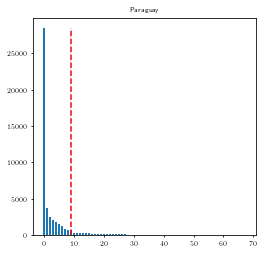

In [886]:
for case_dict in plot_countries_dict.values():
    d_matrix = None
    norm = None
    include_reg = True
    region = case_dict['region']
    cc = case_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, case_dict['cell_size'], 'geojson')
    cell_plot_df = geopd.read_file(cell_data_path)
    cell_plot_df, plot_lings_dict = metrics.calc_by_cell(cell_plot_df, plot_lings_dict)

    total_count = cell_plot_df['total_count'].sort_values(ascending=False)
    pop_cumsum = total_count.cumsum()
    pop_cumprop = pop_cumsum / pop_cumsum.iloc[-1]
    loc_percentile = np.searchsorted(pop_cumprop, 0.90)
    min_pop = int(1 / (total_count / pop_cumsum.iloc[-1]).iloc[loc_percentile])
    
    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.bar(np.array(range(len(total_count))), total_count)
    ax.vlines(loc_percentile, 0 , total_count.max(), colors='r', ls='dashed')
    ax.set_title(area_name)
    fig.show()
    break

In [923]:
hard_min_pop = 50
nr_emr_iter = 50
# countries = []
# y_EMD_patt = re.compile('EMD_[a-z]{2}_vs_tot')
# xaxis_metric_label = r'$\langle \textrm{EMR}_{L} \rangle$'
# x_EMD_patt = re.compile('EMD_ling_[a-z]{2}_vs_tot')
xaxis_metric_label = r'$\textrm{EMR}_{\textrm{mono}}$'
# y_EMD_patt = re.compile('EMD_ling_[a-z]{3,}_vs_tot')
yaxis_metric_label = r'$\textrm{EMR}_{\textrm{multi}}$'
# y_EMD_patt = re.compile('EMD_multi')
# yaxis_metric_label = r'$\textrm{EMR}_{\textrm{multi}}$'
# xaxis_metric = []
# yaxis_metric = []
for case_dict in plot_countries_dict.values():
    d_matrix = None
    norm = None
    include_reg = True
    region = case_dict['region']
    cc = case_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, case_dict['cell_size'], 'geojson')
    cell_plot_df = geopd.read_file(cell_data_path)
    cell_plot_df, plot_lings_dict = metrics.calc_by_cell(cell_plot_df, plot_lings_dict)

    total_count = cell_plot_df['total_count'].sort_values(ascending=False)
    pop_cumsum = total_count.cumsum()
    pop_cumprop = pop_cumsum / pop_cumsum.iloc[-1]
    loc_percentile = np.searchsorted(pop_cumprop, 0.90)
    min_pop = int(1 / (total_count.iloc[loc_percentile] / pop_cumsum.iloc[-1]))
    x_array = []
    y_array = []
    total_count = sum([case_dict[f'count_{grp}'] for grp in plot_lings_dict])
    for grp in plot_lings_dict.keys():
        grp_count = int(case_dict[f'count_{grp}'])
        test = grp_count > min_pop
        if grp_count > hard_min_pop and (not test):
            # boostrap emr calc
            cum_distrib = cell_plot_df['conc_'+grp].cumsum().values
            draws = np.random.random((nr_emr_iter, grp_count))
            assignments = np.searchsorted(cum_distrib, draws)
            emrs = np.zeros(nr_emr_iter)
            for i in range(nr_emr_iter):
                i_cells, counts = np.unique(assignments[i], return_counts=True)
                cell_plot_df['sample_conc'] = 0
                cell_plot_df['sample_conc'].iloc[i_cells] = counts / grp_count
                emd_value, norm, d_matrix = metrics.earthmover_distance(
                    cell_plot_df, 'sample_conc', 'total_conc', d_matrix=d_matrix, norm=norm)
                emrs[i] = emd_value / norm
            mean_emr = emrs.mean()
            rel_std = emrs.std() / mean_emr
#             case_dict[f'EMD_{grp}_vs_tot'] = mean_emr
            test = rel_std < 0.2
            print(grp, area_name, grp_count, min_pop, case_dict[f'EMD_{grp}_vs_tot'], mean_emr, rel_std)
        if test:
            if len(grp) > 7:
                y_array.append(case_dict[f'EMD_{grp}_vs_tot'])
            else:
                x_array.append(case_dict[f'EMD_{grp}_vs_tot'])
        else:
            print(f'{area_name} excluded because of {grp}')
#             include_reg = False
    if include_reg:
        countries.append(case_dict['name'])
        xaxis_metric.append(np.array(x_array))
        yaxis_metric.append(np.array(y_array))
# # xaxis_metric = [np.array([case_dict[key]
# #                           for key in case_dict.keys()
# #                           if re.match(x_EMD_patt, key)])
# #                 for case_dict in plot_countries_dict.values()]
# # yaxis_metric = [np.array([case_dict[key]
# #                           for key in case_dict.keys()
# #                           if re.match(y_EMD_patt, key)])
# #                 for case_dict in plot_countries_dict.values()]

/home/thomaslouf/Documents/code/multiling-twitter/.cenv/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ling_defr Switzerland 287 1005 0.2533416832297027 0.26568227371901476 0.07434416702672553
ling_deit Switzerland 131 1005 0.5779943482408351 0.5960957694883815 0.03865400741315096
ling_frit Switzerland 142 1005 0.5769592867872799 0.5842020936554099 0.06532036776039006
Switzerland excluded because of ling_defrit


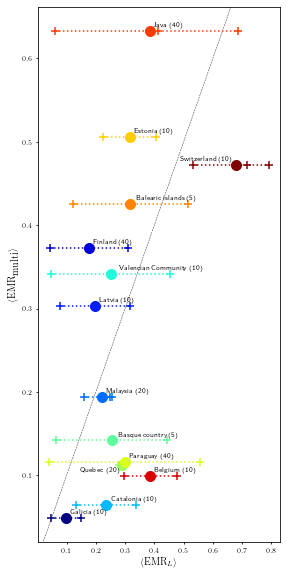

In [669]:
pt_labels = [re.match(r'([A-Za-z\s]+)([0-9]+)', c).groups() for c in countries]
pt_labels = [f'{l[0]} ({l[1]})' for l in pt_labels]
fig_save_path = os.path.join(fig_dir, 'all',
                         'EMR_all_multilings_vs_avg_langs+err.pdf')
fig, ax = helpers_viz.errorbar_labelled(
    xaxis_metric, yaxis_metric, pt_labels, xlabel=xaxis_metric_label,
    ylabel=yaxis_metric_label, figsize=(4,8), save_path=None, pts_s=10,
    show_xerr=True, show_yerr=False,
    **{'scatter': {'s': 8**2, 'marker': '+'},
       'adj_text': {'expand_text': (1.05, 1.2), 'expand_points': (1.2, 1.5),
                    'only_move': {'points': 'xy', 'text': 'xy', 'objects': 'xy'}}})
ax.yaxis.label.set_size(plt.rcParams['font.size'] + 3)
ax.xaxis.label.set_size(plt.rcParams['font.size'] + 3)
ax.autoscale(False)
guide_c = np.array([50]*3) / 255
_ = ax.plot([0, 1], [0, 1], ls='--', c=guide_c, lw=0.5, zorder=1)
fig.savefig(fig_save_path)

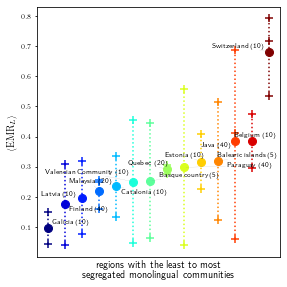

In [688]:
pt_labels = [re.match(r'([A-Za-z\s]+)([0-9]+)', c).groups() for c in countries]
pt_labels = [f'{l[0]} ({l[1]})' for l in pt_labels]
pts_s = 8
fig_save_path = os.path.join(fig_dir, 'all',
                         'EMR_all_multilings_vs_avg_langs+err.pdf')
fig, ax = helpers_viz.cat_errorbar_labelled(
    xaxis_metric, pt_labels, xlabel='regions with the least to most\nsegregated monolingual communities',
    ylabel=xaxis_metric_label, figsize=(4,4), save_path=None, pts_s=pts_s,
    show_yerr=True,
    **{'scatter': {'s': (pts_s-2)**2, 'marker': '+'},
       'adj_text': {'expand_text': (1.05, 1.2), 'expand_points': (1.2, 1.5),
                    'only_move': {'points': 'xy', 'text': 'xy', 'objects': 'xy'}}})
ax.yaxis.label.set_size(plt.rcParams['font.size'] + 3)
ax.xaxis.label.set_size(plt.rcParams['font.size'] + 3)
fig.show()

## Maps + EMD 

In [694]:
import matplotlib.colors as mcolors

In [695]:
plt.rc('axes', labelsize=small_size, titlesize=small_size)

In [696]:
cc_region = {'BE': {'shpfile_name': 'Apn_AdRe.shp', 'extract_shape_kwargs': dict(min_area=10**4, simplify_tol=50)}, 
             'ES': {'region': 'Catalonia'}}
cell_size = 10000
for cc, cc_dict in cc_region.items():
    region = cc_dict.get('region')
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    cc_dict['xy_proj'] = xy_proj
    cc_dict['local_langs'] = area_dict['local_langs']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
    shpfile_name = cc_dict.get('shpfile_name', shapefile_dict['name'])
    shapefile_path = os.path.join(
        external_data_dir, shpfile_name, shpfile_name)
    shape_df = geopd.read_file(shapefile_path)
    shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj, 
                                 **cc_dict.get('extract_shape_kwargs', {}))
    cc_dict['shape_df'] = shape_df

    cell_data_path = cell_data_path_format.format(
        'users_cell_data', cc, area_name, cell_size, 'geojson')
    cell_plot_df = geopd.read_file(cell_data_path)
    cell_plot_df.index = cell_plot_df['cell_id']
    cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
        cell_plot_df, plot_langs_dict, cell_size=cell_size)
    cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
        cell_plot_df, plot_lings_dict, cell_size=cell_size)
    cell_plot_df = cell_plot_df.loc[cell_plot_df['local_count'] > 10]
    cc_dict['cell_plot_df'] = cell_plot_df
    cc_dict['plot_langs_dict'] = plot_langs_dict
    plot_lings_dict[list(plot_lings_dict.keys())[-1]]['grp_label'] = 'bilinguals'
    cc_dict['plot_lings_dict'] = plot_lings_dict

In [918]:
xaxis_metric_label = r'$\textrm{EMR}_{\textrm{mono}}$'
yaxis_metric_label = r'$\textrm{EMR}_{\textrm{multi}}$'

/home/thomaslouf/Documents/code/multiling-twitter/.cenv/lib/python3.7/site-packages/matplotlib/transforms.py:623: RuntimeWarning:

invalid value encountered in double_scalars

/home/thomaslouf/Documents/code/multiling-twitter/.cenv/lib/python3.7/site-packages/matplotlib/transforms.py:624: RuntimeWarning:

invalid value encountered in double_scalars



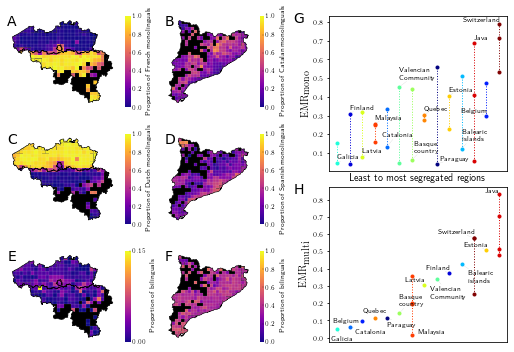

In [935]:
import copy
import re
from itertools import chain
fig = plt.figure(figsize=(17.8/2.54, 12.2/2.54), constrained_layout=False)
tight_layout = False

plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.1,
               'cmap': 'plasma', 'rasterized': True}
maps_kwargs = {
    **dict(
        show=False, tight_layout=tight_layout, cbar_lw=0, vmin=0, vmax=1, 
        borderwidth=0.5),
    **{'plot': plot_kwargs, 'annotate': annotate_kwargs}}
biling_maps_kwargs = copy.deepcopy(maps_kwargs)
biling_maps_kwargs.pop('vmax')

shape_list = [cc_dict['shape_df'] for cc_dict in cc_region.values()]
width_ratios = grid_viz.get_width_ratios(shape_list, ratio_lgd=0.4)
gs = fig.add_gridspec(
    1, 2, width_ratios=[width_ratios[0]+width_ratios[1], width_ratios[2]],
    left=0, right=1, bottom=0.02, top=0.96, wspace=0.27)
# gs_maps = gs[0].subgridspec(3, 2, width_ratios=width_ratios[:-1], hspace=0.3, wspace=0.3)
gs_maps = gs[0].subgridspec(3, 2, width_ratios=width_ratios[:-1], hspace=0.3, wspace=0.2)
gs_emrs = gs[1].subgridspec(2, 1, hspace=0.1)
fig.set_constrained_layout_pads(w_pad=0, hpad=0, wspace=0.1, hspace=0.1)
# Always start by creating all axes, and then and only then plot in them!
axes = []
for g in chain(gs_maps, gs_emrs):
    axes.append(fig.add_subplot(g))

cc = 'BE'
cell_plot_df = cc_region[cc]['cell_plot_df']
shape_df = cc_region[cc]['shape_df']
xy_proj = cc_region[cc]['xy_proj']
plot_langs_dict = cc_region[cc]['plot_langs_dict']
plot_lings_dict = cc_region[cc]['plot_lings_dict']
for i, grp_dict in enumerate(plot_lings_dict.values()):
    i_ax = 2*i
    cbar_label = f"{prop_dict['readable']} of {grp_dict['grp_label']}"
    if i == 2:
        kwargs = {**biling_maps_kwargs, **{'cbar_ticks': [0, 0.15]}}
    else:
        kwargs = maps_kwargs
    fig, axes[i_ax] = grid_viz.plot_grid(
        cell_plot_df, shape_df, ax=axes[i_ax], fig=fig, xy_proj=xy_proj, metric_col=grp_dict['prop_col'],
        cbar_label=cbar_label, **kwargs)
    _ = axes[i_ax].annotate(annotations[i_ax], (0, 0.9),
                            xycoords='axes fraction', **annotate_kwargs)


cc = 'ES'
cell_plot_df = cc_region[cc]['cell_plot_df']
shape_df = cc_region[cc]['shape_df']
xy_proj = cc_region[cc]['xy_proj']
plot_langs_dict = cc_region[cc]['plot_langs_dict']
plot_lings_dict = cc_region[cc]['plot_lings_dict']
for i, grp_dict in enumerate(plot_lings_dict.values()):
    i_ax = 2*i+1
    cbar_label = f"{prop_dict['readable']} of {grp_dict['grp_label']}"
    if i == 2:
        kwargs = biling_maps_kwargs
    else:
        kwargs = maps_kwargs
    fig, axes[i_ax] = grid_viz.plot_grid(
        cell_plot_df, shape_df, ax=axes[i_ax], fig=fig, xy_proj=xy_proj, metric_col=grp_dict['prop_col'],
        cbar_label=cbar_label, **maps_kwargs)
    _ = axes[i_ax].annotate(annotations[i_ax], (0, 0.9),
                            xycoords='axes fraction', **annotate_kwargs)


pt_labels = [re.match(r'([A-Za-z\s]+)([0-9]+)', c).groups() for c in countries]
pt_labels = ['\n'.join(l[0].split(' ')) for l in pt_labels]
pts_s = 5
xlabels = [
    None
    for grp in ['mono', 'multi']]
gen = zip(axes[6:8], [xaxis_metric, yaxis_metric], xlabels, 
          [xaxis_metric_label, yaxis_metric_label], annotations[6:8])
for ax, y_plot, xlabel, ylabel, annot in gen:
    fig, ax = helpers_viz.cat_errorbar_labelled(
        y_plot, pt_labels, xlabel=xlabel, ylabel=ylabel, pts_s=pts_s,
        show_yerr=True, fig=fig, ax=ax, tight_layout=False,
        **{'scatter': {'s': (pts_s-2)**2, 'marker': 'o'},
           'adj_text': {'expand_text': (1.1, 1.2), 'expand_points': (1.2, 2),
                        'expand_objects': (2, 2), 'force_objects': (2, 3),
                        'only_move': {'points': 'y', 'text': 'xy', 'objects': 'y'}}})
    ax.yaxis.label.set_size(plt.rcParams['font.size'] + 3)
    _ = ax.annotate(annot, (-0.2, 0.96), #0.15
                    xycoords='axes fraction', **annotate_kwargs)
axes[-1].set_title('Least to most segregated regions')
axes[-1].title.set_size(plt.rcParams['font.size']+3)
fig_save_path = os.path.join(fig_dir, 'all', 'BE_CAT_maps_EMRs_ranked.pdf')
fig.savefig(fig_save_path, dpi=400)
fig.show()

# Data table 

In [867]:
import itertools
list_EMR = []
list_counts = []
list_grps = []
list_regions = []
list_cell_sizes = []
for _, cc_dict in sorted(plot_countries_dict.items()):
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    for grp, grp_dict in itertools.chain(plot_langs_dict.items(),
                                         plot_lings_dict.items()):
        list_grps.append(grp_dict['grp_label'])
        list_counts.append(cc_dict[f"count_{grp}"])
        list_EMR.append(cc_dict[f"EMD_{grp}_vs_tot"])
        list_regions.append(area_name)
        list_cell_sizes.append(int(cc_dict['cell_size']/1000))
summary_table = pd.DataFrame({'Count': list_counts, 'EMR': list_EMR},
                             index=[list_regions, list_cell_sizes, list_grps])
summary_table = (summary_table.rename_axis(index=['Region', 'Cell size (in km)', 'Group'])
                              .assign(EMR = lambda df: np.round(df['EMR'], 3))
                              .astype({'Count': int}))

In [868]:
summary_table_tex = summary_table.reset_index()
mask = summary_table_tex['Region'].duplicated()
summary_table_tex.loc[mask, ['Region', 'Cell size (in km)']] = None
summary_table_tex.to_csv(os.path.join(processed_data_dir, 'summary_table_tex.csv'), index=False)

In [186]:
countries_dict = {
    'Paraguay': {'cc': 'PY', 'region': None, 'cell_sizes': [40000]},
    'Switzerland': {'cc': 'CH', 'region': None, 'cell_sizes': [10000]},
    'Belgium': {'cc': 'BE', 'region': None, 'cell_sizes': [10000]},
    'Catalonia': {'cc': 'ES', 'region': 'Catalonia', 'cell_sizes': [10000]},
    'Balearic islands': {'cc': 'ES', 'region': 'Balearic islands', 'cell_sizes': [5000]},
    'Galicia': {'cc': 'ES', 'region': 'Galicia', 'cell_sizes': [10000]},
    'Valencian Community': {'cc': 'ES', 'region': 'Valencian Community', 'cell_sizes': [10000]},
    'Basque country': {'cc': 'ES', 'region': 'Basque country', 'cell_sizes': [5000]},
    'Latvia': {'cc': 'LV', 'region': None, 'cell_sizes': [10000]},
    'Quebec': {'cc': 'CA', 'region': 'Quebec', 'cell_sizes': [20000]},
    'Malaysia': {'cc': 'MY', 'region': None, 'cell_sizes': [20000]},
    'Java': {'cc': 'ID', 'region': 'Java', 'cell_sizes': [40000]},
    'Luxembourg': {'cc': 'LU', 'region': None, 'cell_sizes': [5000]},
}
lang_EMR_dict = {}
for _, cc_dict in sorted(countries_dict.items()):
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    lang_EMR_dict[area_name] = {}
    for l, l_dict in plot_langs_dict.items():
        name = f"{area_name}{cc_dict['cell_sizes'][0]/1000:.0f}"
        EMR_name = f"EMD_{l}_vs_tot"
        lang = l_dict['readable']
        lang_EMR_dict[area_name][lang] = plot_countries_dict[name][EMR_name]

In [226]:
lang_EMR_df = pd.DataFrame(lang_EMR_dict).T.stack().rename('EMR').rename_axis(index=['Region', 'Language'])
lang_EMR_df.to_csv('EMR_langs.csv')

In [227]:
lang_EMR_tex = lang_EMR_df.reset_index()
mask = lang_EMR_tex['Region'].duplicated()
lang_EMR_tex.loc[mask, 'Region'] = ''
lang_EMR_tex.to_csv('EMR_langs_tex.csv', index=False)

# Cell size invariance

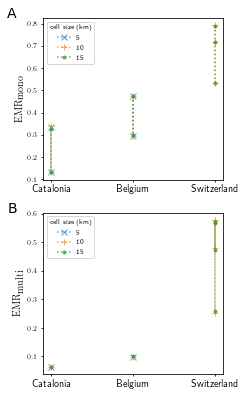

In [974]:
with open(metrics_save_path) as f:
    data_countries_dict = json.load(f)

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(2, 1, figsize=(8.7/2.54, 14/2.54))
xticks = np.array([1, 2, 3])
EMD_names = ('avg_emd_monolings', 'EMD_multi')
ylabels = (r'$\textrm{EMR}_{\textrm{mono}}$', 
           r'$\textrm{EMR}_{\textrm{multi}}$')
patts = [re.compile('EMD_ling_[a-z]{2}_vs_tot'),
         re.compile('EMD_ling_[a-z]{4,}_vs_tot')]
annotations = ('A', 'B')
regions = ['Catalonia', 'Belgium', 'Switzerland']
for ax, ylabel, metric, annotation, patt in zip(axes, ylabels, EMD_names, annotations[:2], patts):
    labels = ['5', None]
    for i in range(2):
        y_plot = [y for key, y in data_countries_dict[f'{regions[i]}5'].items() if re.match(patt, key)]
        ax.plot(
            [xticks[i]]*len(y_plot),
            y_plot,
            c=cmap[0],
            alpha=0.7,
            label=labels[i],
            ls=':',
            marker='x',
            ms=6)
    labels = ['10', None, None]
    for i in range(3):
        y_plot = [y for key, y in data_countries_dict[f'{regions[i]}10'].items() if re.match(patt, key)]
        ax.plot(
            [xticks[i]]*len(y_plot),
            y_plot,
            c=cmap[1],
            alpha=0.7,
            label=labels[i],
            ls=':',
            marker='+',
            ms=6)
    labels = ['15', None, None]
    for i in range(3):
        y_plot = [y for key, y in data_countries_dict[f'{regions[i]}15'].items() if re.match(patt, key)]
        ax.plot(
            [xticks[i]]*len(y_plot),
            y_plot,
            c=cmap[2],
            alpha=0.7,
            label=labels[i],
            ls=':',
            marker='.',
            ms=6)
    ax.set_xticks(xticks)
    ax.set_xticklabels(('Catalonia', 'Belgium', 'Switzerland'), fontsize=small_size+3)
    ax.set_ylabel(ylabel, fontsize=small_size+3)
    ax.legend(title='cell size (km)')
    ax.annotate(annotation, (-0.2, 1), xycoords='axes fraction',
                **annotate_kwargs)
fig.set_tight_layout(True)
fig.savefig(os.path.join(fig_dir, 'all', 'EMR_cell_size_invariance.pdf'))
fig.show()